# Statistical Modeling of Diffuse Solar Irradiance from Direct Irradience and Cloud Cover measurements

In [99]:
#IMPORTS
import pandas as pd
import os
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import pylab as py
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
print(os.listdir())

['data_munger.py', 'Testing_Data', 'statistical_irradience_modeling.ipynb', '.DS_Store', '.irradience_fitter.ipynb.icloud', '.Data_Viz 2.ipynb.icloud', 'playing_with_pvlib.ipynb', 'statistical_modeling.py', 'Raw_Data', 'README.md', 'psm_VA_Charlottesville2018cloud_output.csv', '.ipynb_checkpoints', '.statisical_irradience_modeling 3.ipynb.icloud', '.git']


In [100]:
#Time for Polynomial Fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, median_absolute_error
#Okay none of these are super good. Lets do a boxcox transformation
from sklearn.preprocessing import power_transform

In [101]:
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')


In [102]:
def logify_df(df):
    df['DHI_log'] = np.log(df['DHI'])
    df['GHI_log'] = np.log(df['GHI'])
    df['cloud_cover_log'] = np.log(df['Cloud Cover'])
    return df

In [103]:
def make_df_nonzero(df):
    df_no_zero = df.loc[df['DHI']!= 0 ]
    assert len(df_no_zero['DHI'])==len(df_no_zero['GHI']), "Some DHI 0s where GHI is not 0"
    print(df_no_zero)
    return df_no_zero 

In [104]:
def seasonize(df):
    seasons = []
    for month in df['Month']:
        if month in [12,1,2,3]:
            seasons.append('Winter')
        elif month in [4,5,6]:
            seasons.append('Spring')
        elif month in [7,8,9]:
            seasons.append('Summer')
        else:
            seasons.append('Fall')
    df['Season'] = pd.Series(seasons)
    return df
        

In [105]:
def meta_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, fit_reg=False)
    plt.show()
    return

In [106]:
def segment_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, row=z, fit_reg=True)
    plt.show()
    return

In [107]:
def three_dee_viz(x,y,z,preds):
    #3d viz
    fig = pyplot.figure()
    ax = Axes3D(fig)
    ax.set(xlabel='arg1', ylabel='arg2', zlabel='arg3')
    ax.scatter(x,y,z)
    if len(preds):
        ax.scatter(x, y,preds)
    plt.show()

In [108]:
def resids_viz(actuals, predictions):
    sns.set_style('darkgrid')
    fig, axs = plt.subplots(ncols=2)
    residuals = actuals - predictions
    sm.qqplot(residuals, line='45', ax=axs[0])
    sns.regplot(x=predictions, y=residuals, ax=axs[1], label="Residual vs fitted")
    axs[1].set(xlabel='Fitted', ylabel='Residuals')


In [109]:
def make_OLS(X, Y):
    ols_model = LinearRegression().fit(X, Y)
    r2 = ols_model.score(X, Y)
    print("r2 is ", r2)
    return ols_model, r2

In [110]:
def show_model_metrics(X, Y, model):
    preds = model.predict(X)
    resids = Y - preds
    rmse = np.sqrt(mean_squared_error(Y,preds))
    r2 = r2_score(Y,preds)
    print("rmse is ", rmse)
    print("r2 is ",r2)
    print("mean absolute error is ",mean_absolute_error(Y,preds))
    print("mean squared log error is ", mean_squared_log_error(Y, preds))
    print("median absolute error is ", median_absolute_error(Y, preds))
    print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)
    return preds, resids

## South Dakota 2018 Data, aka the original data 

In [111]:
#Get 2018 Data
df1_2018 = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_testing_data2018.csv'))

In [112]:
print(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
0     2018      1    1     0      30        -22.5             0             0   
1     2018      1    1     1      30        -23.1             0             0   
2     2018      1    1     2      30        -23.6             0             0   
3     2018      1    1     3      30        -23.9             0             0   
4     2018      1    1     4      30        -24.1             0             0   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   
8759  2018     12   31    23      30        -15.1             0             0   

      Clearsky GHI  Cloud T

In [113]:
#Zeros are removed because it ends up recording hours of night time data
#We dont need to record when sunlight is 0
df1_2018 = make_df_nonzero(df1_2018)
logify_df(df1_2018)


      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud Type  ...  Surface Albedo  Pressure  \
14              29           8  ...            0.69       978   
15             171           8  ...            0.69       978   
16             306           0  ...            0.69       978   
17             400           0  ...            0.69       977   
18             440           0  ...            0.69       976   
...            ...         ...  ...             ...       ...   
8754           414           4  ...            0.70       960   
8755           397           4  ...            0.70       961   
8756           327           4  ...            0.70       962   
8757           212           4  ...            0.70       963   
8758            75           7  ...            0.70       964   

      Precipitable Water  Wind Direction  Wind Speed  timestamps  Cloud Cover  \
14                   0.1             236         1.2  1514790000         0.44   
15                   0.1             216         1.2  1514793600         1.00   
16                   0.1             194         1.4  1514797200         0.75   
17                   0.1             174         1.6  1514800800         0.44   
18                   0.1             157         1.9  1514804400         0.19   
...                  ...             ...         ...         ...          ...   
8754                 0.6             356         8.5  1546254000         1.00   
8755                 0.6             355         8.4  1546257600         1.00   
8756                 0.5             353         8.2  1546261200         1.00   
8757                 0.4             352         7.6  1546264800         1.00   
8758                 0.4             350         6.8  1546268400         0.99   

       DHI_log   GHI_log  cloud_cover_log  
14    2.484907  2.639057        -0.820981  
15    3.970292  4.663439         0.000000  
16    4.094345  5.613128        -0.287682  
17    4.158883  5.929589        -0.820981  
18    4.025352  6.086775        -1.660731  
...        ...       ...              ...  
8754  4.158883  5.945421         0.000000  
8755  4.615121  5.755742         0.000000  
8756  4.488636  5.549076         0.000000  
8757  4.234107  5.036953         0.000000  
8758  3.496508  3.912023        -0.010050  

[4494 rows x 27 columns]

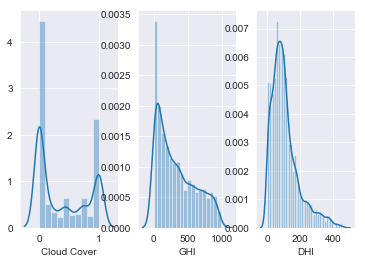

In [114]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI'], ax=axs[1])
sns.distplot(df1_2018['DHI'], ax=axs[2])

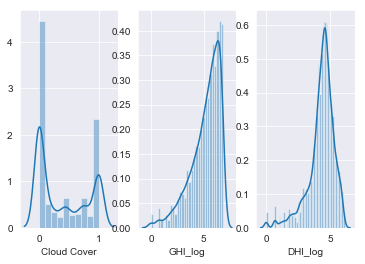

In [115]:
#Take a look at data distribution in logs
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI_log'], ax=axs[1])
sns.distplot(df1_2018['DHI_log'], ax=axs[2])

In [116]:
"""
Assumptions of Linear Regression:

1.Linearity: The relationship between X and the mean of Y is linear.
    -IE tthe residuals should be normally distributed
2.Homoscedasticity: The variance of residual is the same for any value of X.
3.Independence: Observations are independent of each other.
4.Normality: For any fixed value of X, Y is normally distributed.

""" 

'\nAssumptions of Linear Regression:\n\n1.Linearity: The relationship between X and the mean of Y is linear.\n    -IE tthe residuals should be normally distributed\n2.Homoscedasticity: The variance of residual is the same for any value of X.\n3.Independence: Observations are independent of each other.\n4.Normality: For any fixed value of X, Y is normally distributed.\n\n'

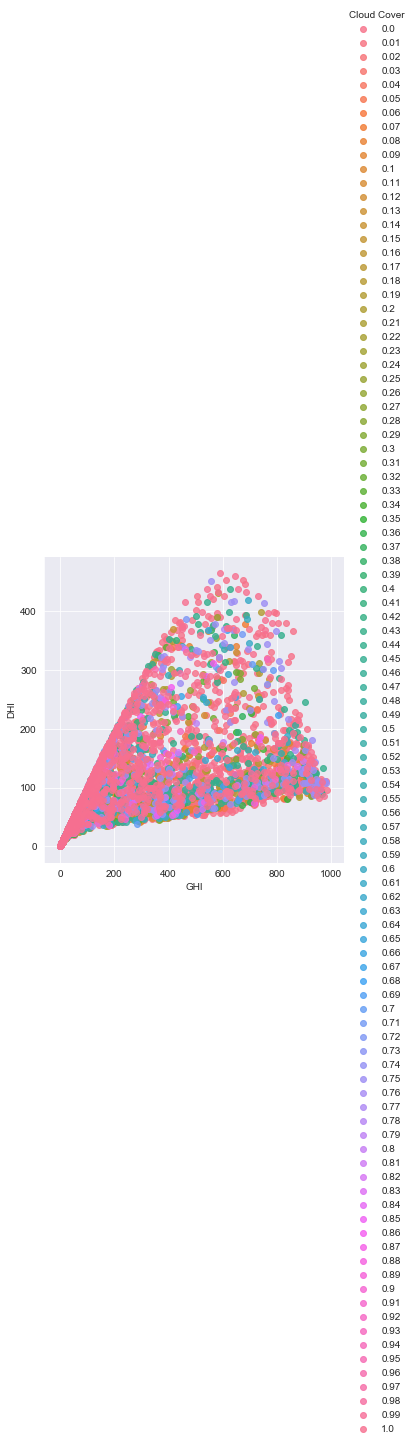

In [117]:
#See the overall data
sns.lmplot('GHI', 'DHI', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

## Polynomial fit with log transform of response 

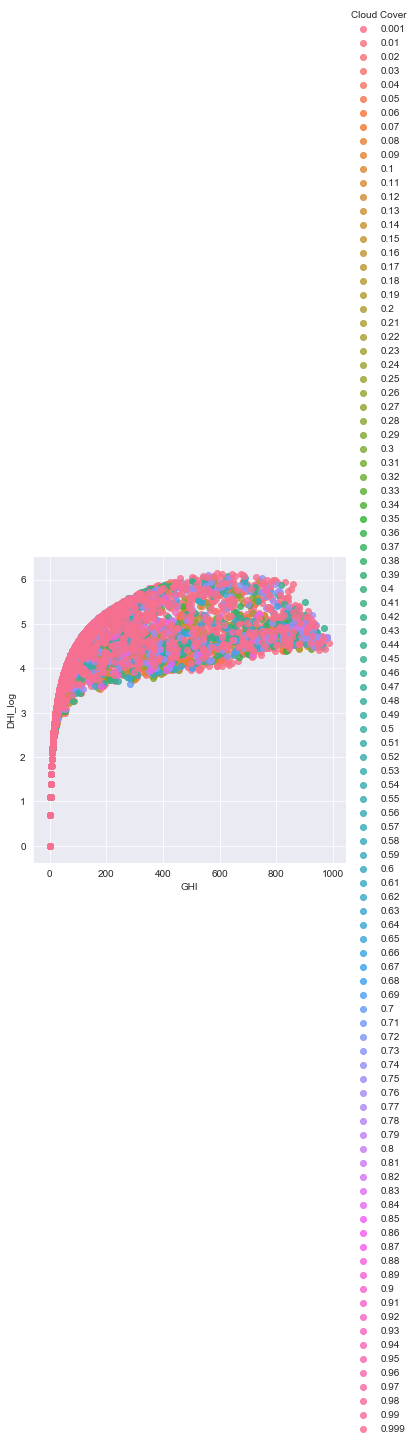

In [209]:
meta_visualization(df1_2018, x='GHI', y='DHI_log', z='Cloud Cover')

In [119]:
#Need to fit some poly stuff
#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

In [120]:
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(_X)
log_actuals = df1_2018['DHI_log']

In [237]:
clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_poly, log_actuals)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [238]:
print(clf_poly.coef_)

[ 0.00000000e+00  4.10931067e-02  8.25022070e-02 -2.10323379e-04
  1.25931767e-04  3.23971458e-02  4.78464016e-07 -7.89474301e-06
  1.09172396e-02 -2.14491774e-04 -4.89035238e-10  1.21042036e-08
  1.45345267e-06 -1.90833226e-02 -2.21119292e-02  1.83560675e-13
 -7.60606215e-12  2.43441387e-09 -4.04026927e-06  1.11572334e-02
 -3.74068568e-02]


In [239]:
predictions_poly = show_model_metrics(X_poly, log_actuals, clf_poly)[0]

rmse is  0.4991547780071287
r2 is  0.7568685086844883
mean absolute error is  0.39916258513543906
mean squared log error is  0.016365520068935553
median absolute error is  0.3436932169414999
MAPE is  inf


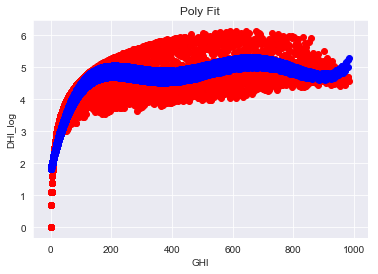

In [240]:
def viz_linear():
    plt.scatter(_GHI, log_actuals, color='red')
    plt.scatter(_GHI, predictions_poly, color='blue')
#     plt.plot(_ghi_poly_sorted, preds_poly_sorted, 's', color='blue')
    plt.title('Poly Fit')
    plt.xlabel('GHI')
    plt.ylabel('DHI_log')
    plt.show()
    return
viz_linear()

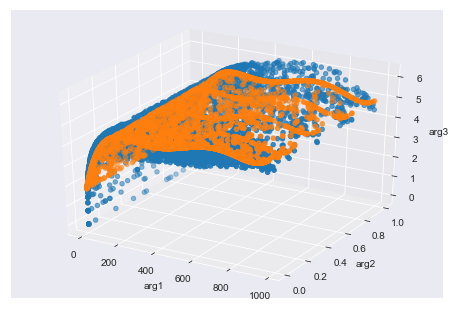

In [241]:
#3D visualizations
# fig = pyplot.figure()
# ax = Axes3D(fig)

# ax.scatter(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI_log'])
# ax.scatter(df1_2018['GHI'], df1_2018['Cloud Cover'], predictions_poly)
# plt.show()
three_dee_viz(_GHI, _Cloud_Cover, log_actuals, predictions_poly )

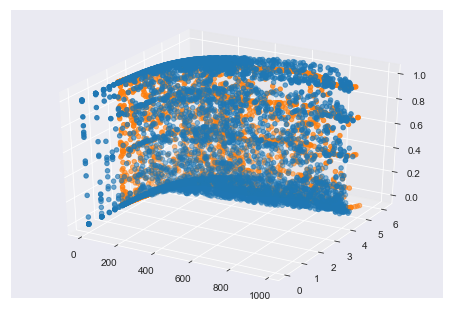

In [242]:
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df1_2018['GHI'], df1_2018['DHI_log'], df1_2018['Cloud Cover'])
ax.scatter(df1_2018['GHI'], predictions_poly, df1_2018['Cloud Cover'])
plt.show()

In [243]:
#Baack transform
preds_back_transformed = np.exp(predictions_poly)
actuals = df1_2018['DHI']
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(actuals,preds_back_transformed))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_back_transformed))
print("median absolute error is ", median_absolute_error(actuals, preds_back_transformed))
print("MAPE is ", np.mean(np.abs((actuals - preds_back_transformed) / actuals)) * 100)

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  43.22293248311914
mean squared log error is  0.22798687434195253
median absolute error is  26.284718752791132
MAPE is  44.6304804335543


In [244]:
#LEts see how our residuals hold up, lets see if we can wrangle this data

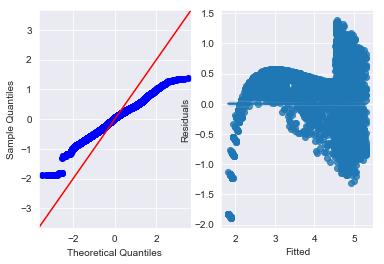

In [245]:
## QQplot and residuals vs. fitted
resids_viz(log_actuals, predictions_poly)

In [130]:
#Residuals are not very normal, not great, not terrible
#model fit is pretty good

In [131]:
"""
For polynomial regression models we assume that:

the behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),
the relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),
the independent variables xi are independent of each other, and
the errors are independent, normally distributed with mean zero and a constant variance (OLS).
"""

'\nFor polynomial regression models we assume that:\n\nthe behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),\nthe relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),\nthe independent variables xi are independent of each other, and\nthe errors are independent, normally distributed with mean zero and a constant variance (OLS).\n'

## Log- Log Transform Fitting

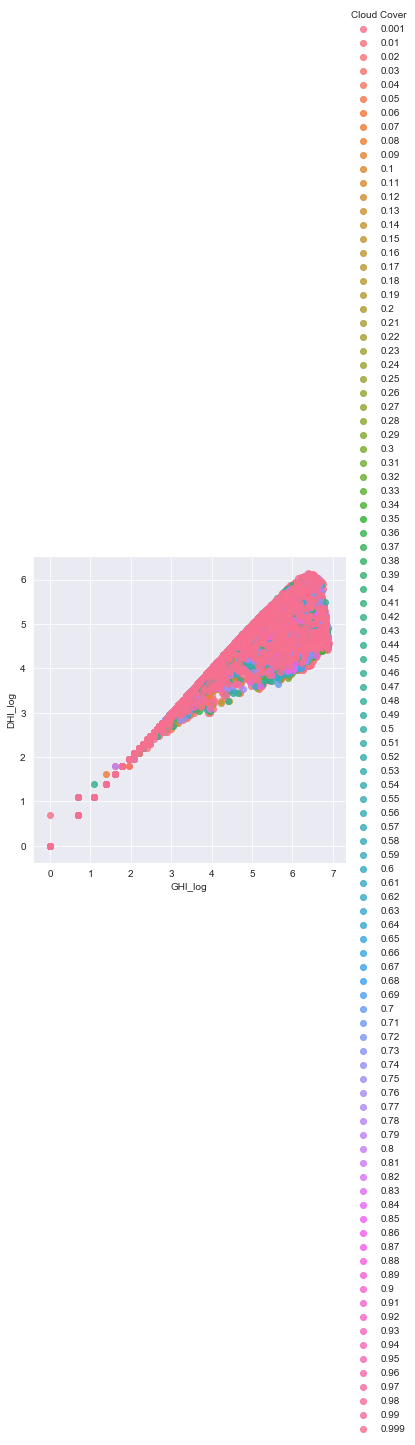

In [210]:
#See the overall data
meta_visualization(df1_2018, 'GHI_log', 'DHI_log', 'Cloud Cover')

In [134]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_GHI_log = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X_log = np.array(list(zip(_GHI_log, _Cloud_Cover)))
log_actuals = df1_2018['DHI_log']

In [212]:
OLS_log_log = make_OLS(_X_log, log_actuals)[0]

r2 is  0.744334589378747


In [213]:
df1_2018_lin_reg.coef_

array([0.62767233, 0.3428279 ])

In [214]:
df1_2018_lin_reg.intercept_

0.9351297431441159

In [230]:
#Predictions and metrics

In [231]:
predictions_log = show_model_metrics(_X_log, log_actuals, OLS_log_log)[0]

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  0.4313808973773106
mean squared log error is  0.012859520120319393
median absolute error is  0.41262900659752355
MAPE is  inf


In [232]:
#Back transform
preds_back_transformed_log = np.exp(predictions_log)
actuals = df1_2018['DHI']
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(actuals,preds_back_transformed_log))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_back_transformed_log))
print("median absolute error is ", median_absolute_error(actuals, preds_back_transformed_log))
print("MAPE is ", np.mean(np.abs((actuals - preds_back_transformed_log) / actuals)) * 100)

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  49.61377521241005
mean squared log error is  0.24871151141706607
median absolute error is  34.92363593702837
MAPE is  45.74211866425743


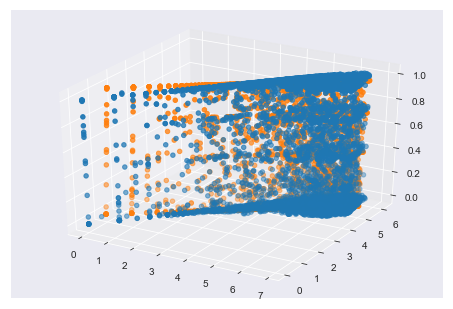

In [222]:
#3d viz
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df1_2018['GHI_log'], df1_2018['DHI_log'], df1_2018['Cloud Cover'])
ax.scatter(df1_2018['GHI_log'], predictions_log, df1_2018['Cloud Cover'])
plt.show()


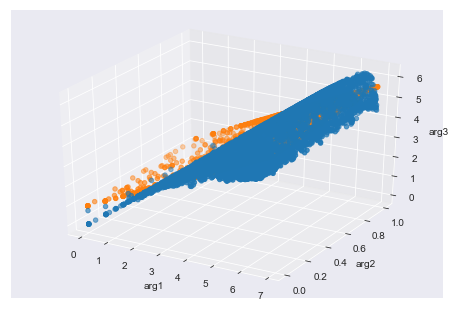

In [223]:
three_dee_viz(_GHI_log, _Cloud_Cover, log_actuals, predictions_log)

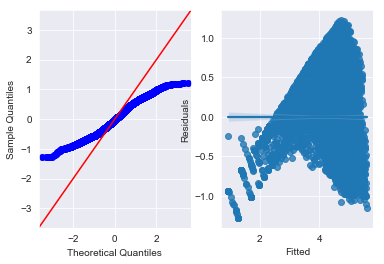

In [143]:
resids_viz(log_actuals, predictions_log)

In [ ]:
#Residual fit not bad not great

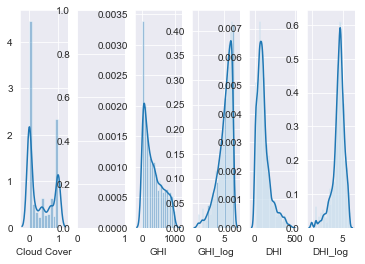

In [148]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
# sns.distplot(df1_2018['cloud_cover_log'], ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(df1_2018['GHI_log'], ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(df1_2018['DHI_log'], ax=axs[5])

In [ ]:
#CONCLUSION: Fit is pretty good

## Power Transform 

In [149]:
box_cox_vector = list(zip(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI']))
box_cox = power_transform(box_cox_vector, method='yeo-johnson')
box_cox_X = list([i[0] for i in box_cox])
box_cox_X2 = list([i[1] for i in box_cox])
box_cox_Y = list([i[2] for i in box_cox])
df1_2018['box_cox_X'] = pd.Series(box_cox_X)
df1_2018['box_cox_X2'] = pd.Series(box_cox_X2)
df1_2018['box_cox_Y'] = pd.Series(box_cox_Y)


[-1.608115178165106, -0.6564237902200389, 0.1134073322024812, 0.436696321488911, 0.6119679144060186, 0.5670662331074078, 0.35711345700351843, -0.05759381872294776, -0.821629189557112, -1.5267116921769899, -0.3807171628153207, 0.09928921492632571, 0.04146428312098943, -0.25644274314783466, -0.27479874646740815, -0.27018557232957036, -0.47462234558160427, -1.3477575704002918, -1.7046771262199352, -0.9324068668132303, -0.045813654201570304, 0.19217543404444515, 0.2924977424447557, 0.45103592405981174, -0.14710947106332886, -0.4965252139923347, -1.0205482783311957, -1.7321935128422972, -0.7357289170635944, 0.03407695648911768, 0.42223636116654234, 0.4135015153681686, 0.3050017717935124, 0.289356782163511, -0.3266579001526746, -0.8994127983051377, -1.6305628397812642, -0.7153364119890179, -0.4319881453793589, 0.16522697645354634, 0.39589661615965993, 0.3540927908768513, 0.16522697645354634, -0.5416000717969112, -1.1505727253915783, -1.5080888299444428, -0.4584564273937915, 0.130874168101529

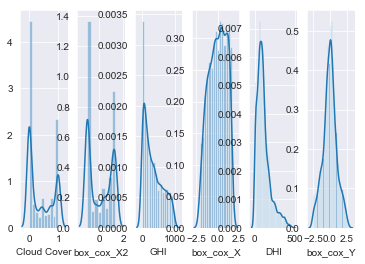

In [150]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['box_cox_X2'], ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(df1_2018['box_cox_X'], ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(df1_2018['box_cox_Y'], ax=axs[5])

In [151]:
#Distributions are much more normal

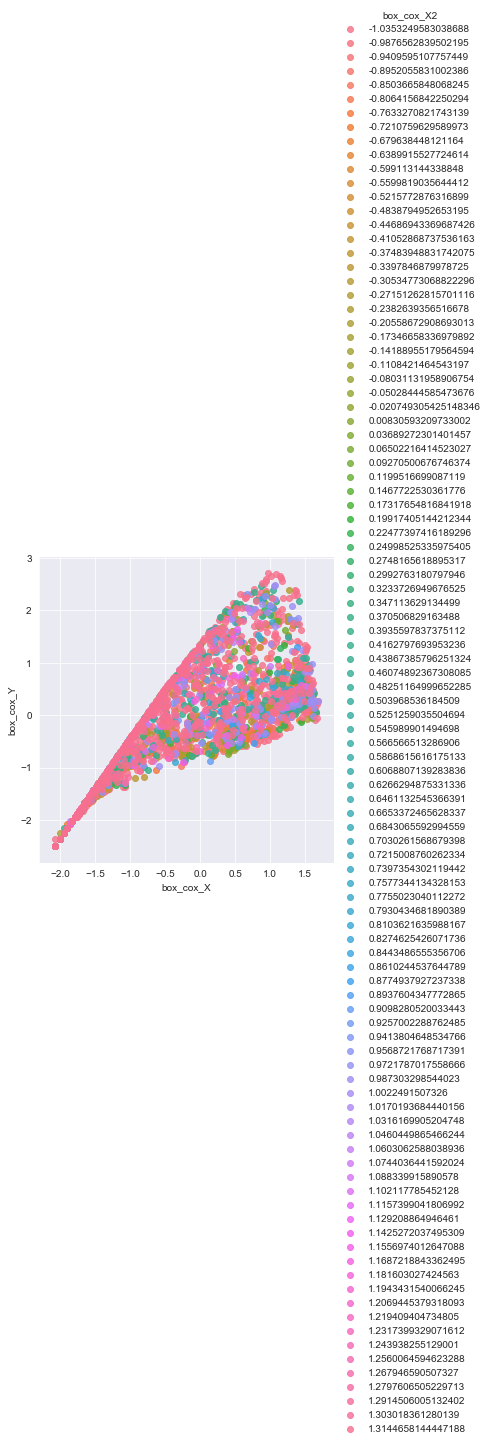

In [225]:
#See the overall data
meta_visualization(df1_2018,'box_cox_X', 'box_cox_Y','box_cox_X2' )

In [153]:
#Still heteroskedastic, whatever, lets fit a curve

In [154]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_ptrans_X1 = df1_2018['box_cox_X'].values
_ptrans_X2 = df1_2018['box_cox_X2'].values
_ptrans_X = np.array(list(zip(_ptrans_X1, _ptrans_X2)))
ptrans_actuals = df1_2018['box_cox_Y'].values
print(len(ptrans_actuals))
print(ptrans_actuals[-990])
print(df1_2018['DHI'].values[-990])

4494
nan
215


In [155]:
#Drop NA
df2018_yeojohnson_transform = df1_2018.dropna()
print(df2018_yeojohnson_transform)
#Redefine the vars
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_df2_ptrans_X1 = df2018_yeojohnson_transform['box_cox_X'].values
_df2_ptrans_X2 = df2018_yeojohnson_transform['box_cox_X2'].values
_df2_ptrans_X = np.array(list(zip(_df2_ptrans_X1, _df2_ptrans_X2)))
_df2_ptrans_actuals = df2018_yeojohnson_transform['box_cox_Y'].values

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
4485  2018      7    6    21      30         31.4           133           790   
4486  2018      7    6    22      30         30.9           116           750   
4487  2018      7    6    23      30         30.5            98           675   
4488  2018      7    7     0      30         28.4            71           564   
4489  2018      7    7     1      30         26.5            40           340   

      Clearsky GHI  Cloud T

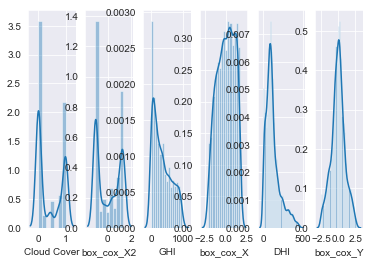

In [156]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df2018_yeojohnson_transform['Cloud Cover'], ax=axs[0])
sns.distplot(df2018_yeojohnson_transform['box_cox_X2'], ax=axs[1])
sns.distplot(df2018_yeojohnson_transform['GHI'], ax=axs[2])
sns.distplot(df2018_yeojohnson_transform['box_cox_X'], ax=axs[3])
sns.distplot(df2018_yeojohnson_transform['DHI'], ax=axs[4])
sns.distplot(df2018_yeojohnson_transform['box_cox_Y'], ax=axs[5])

In [157]:
#Data Distribution still much better

In [158]:
df2018_ptransform_lin_reg = LinearRegression().fit(_df2_ptrans_X, _df2_ptrans_actuals)
df2018_ptransform_lin_reg.score(_df2_ptrans_X, _df2_ptrans_actuals)

0.5152314620121814

In [159]:
df2018_ptransform_lin_reg = LinearRegression().fit(_df2_ptrans_X, _df2_ptrans_actuals)


In [160]:
#BAAAAD score

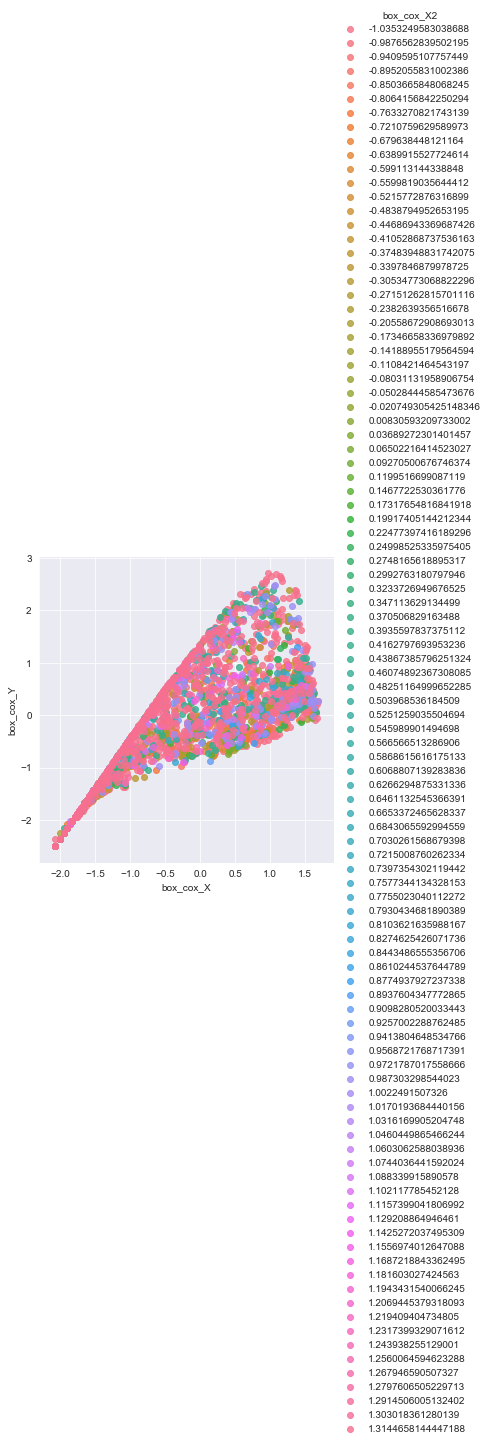

In [161]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='box_cox_X2', fit_reg=False)
plt.show()

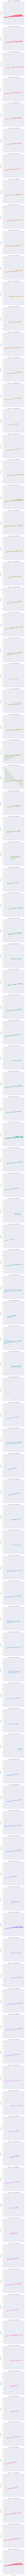

In [162]:
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='box_cox_X2', row='box_cox_X2', fit_reg=True)
plt.show()

In [163]:
#But does not fix heteroskedasticity,
#Possibily because cloud cover data is so skewed

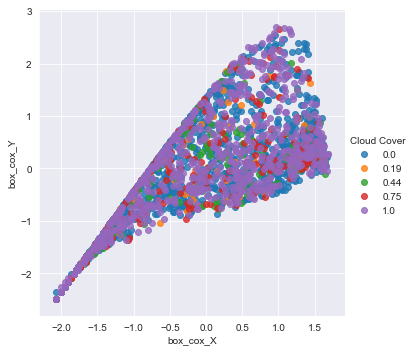

In [164]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='Cloud Cover', fit_reg=False)
plt.show()

In [246]:
#I dont like this model because it involves dropping so much data

## Square root transformation 

In [165]:
#Lets take the square root of everything and see what happens.

In [166]:
ghi_sqrt = np.sqrt(df1_2018['GHI'].values)
dhi_sqrt = np.sqrt(df1_2018['DHI'].values)
cc_sqrt = np.sqrt(df1_2018['Cloud Cover'].values)
df1_2018['ghi_sqrt'] = pd.Series(ghi_sqrt)
df1_2018['dhi_sqrt'] = pd.Series(dhi_sqrt)
df1_2018['cc_sqrt'] = pd.Series(cc_sqrt)

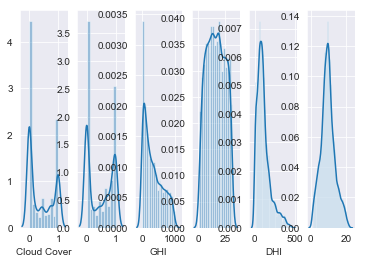

In [167]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(cc_sqrt, ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(ghi_sqrt, ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(dhi_sqrt, ax=axs[5])

In [168]:
#Data is much more normal, this is good

In [247]:
df2018_sqrt_ft = make_OLS(_X_sqrt, dhi_sqrt)[0]

r2 is  0.44908614077505316


In [249]:
#oooooohhhh that's not good
dhi_sqrt_preds = show_model_metrics(_X_sqrt, dhi_sqrt, df2018_sqrt_fit)[0]

rmse is  2.9217933487276126
r2 is  0.44908614077505316
mean absolute error is  2.361639657906579
mean squared log error is  0.082158762510106
median absolute error is  2.0717014056599004
MAPE is  30.678643885731518


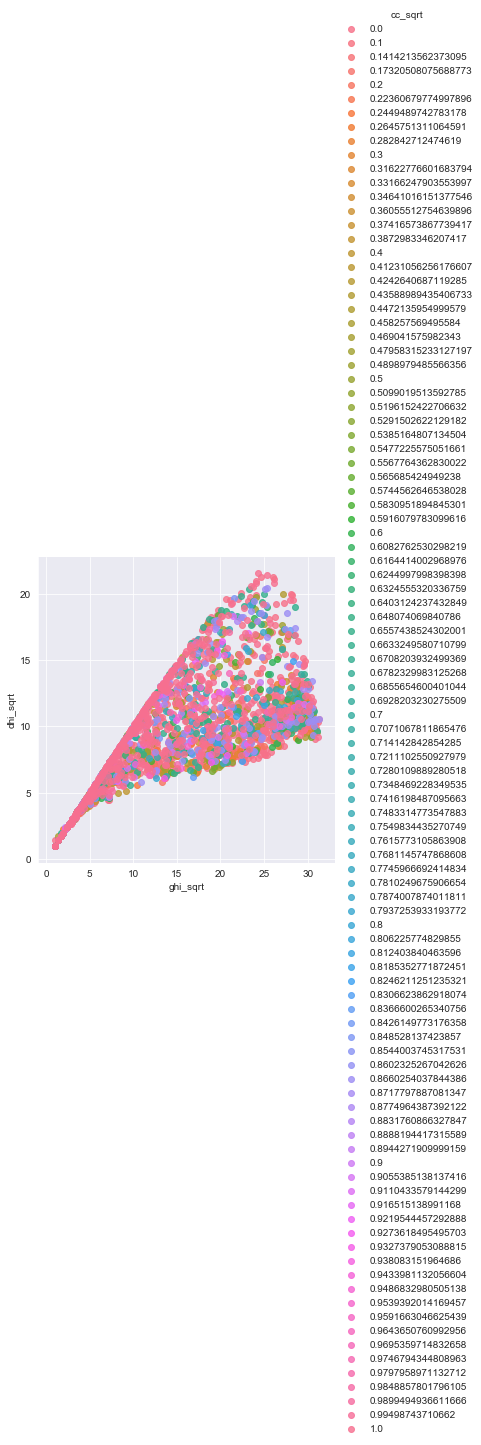

In [250]:
meta_visualization(df1_2018, x='ghi_sqrt', y='dhi_sqrt', z='cc_sqrt')

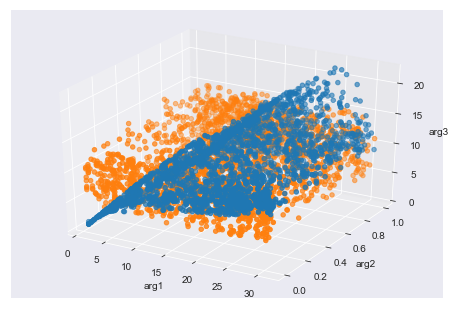

In [251]:
#3d
three_dee_viz(df1_2018['ghi_sqrt'], df1_2018['cc_sqrt'],df1_2018['dhi_sqrt'], dhi_sqrt_preds)

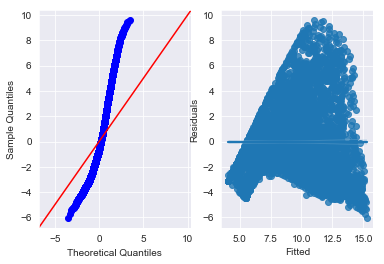

In [252]:
resids_viz(dhi_sqrt, dhi_sqrt_preds)

In [253]:
#SAD!

## Logit Transformation 

In [257]:
#try a logit transformation of cloud cover to bring in tails

In [254]:
from scipy.special import logit

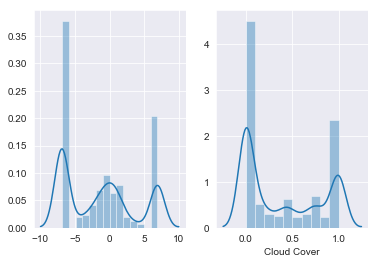

In [258]:
logit_vals = (df1_2018['Cloud Cover'].values)

for i in range(len(logit_vals)):
    if logit_vals[i] ==0:
        logit_vals[i]+=0.001
    elif logit_vals[i]==1:
        logit_vals[i]-=0.001
logit_vals = logit(logit_vals)


sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
sns.distplot(logit_vals, ax=axs[0])
sns.distplot(df1_2018['Cloud Cover'], ax=axs[1])

df1_2018['logt_vals'] = pd.Series(logit_vals)


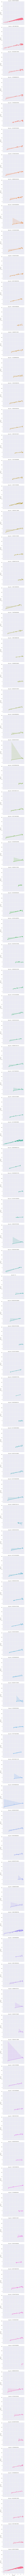

In [259]:

# sns.lmplot('GHI_log', 'DHI_log', data=df1_2018, hue='logt_vals', row='logt_vals', fit_reg=True)
# plt.show()
segment_visualization(df1_2018, x='GHI_log', y='DHI_log', z='logt_vals')

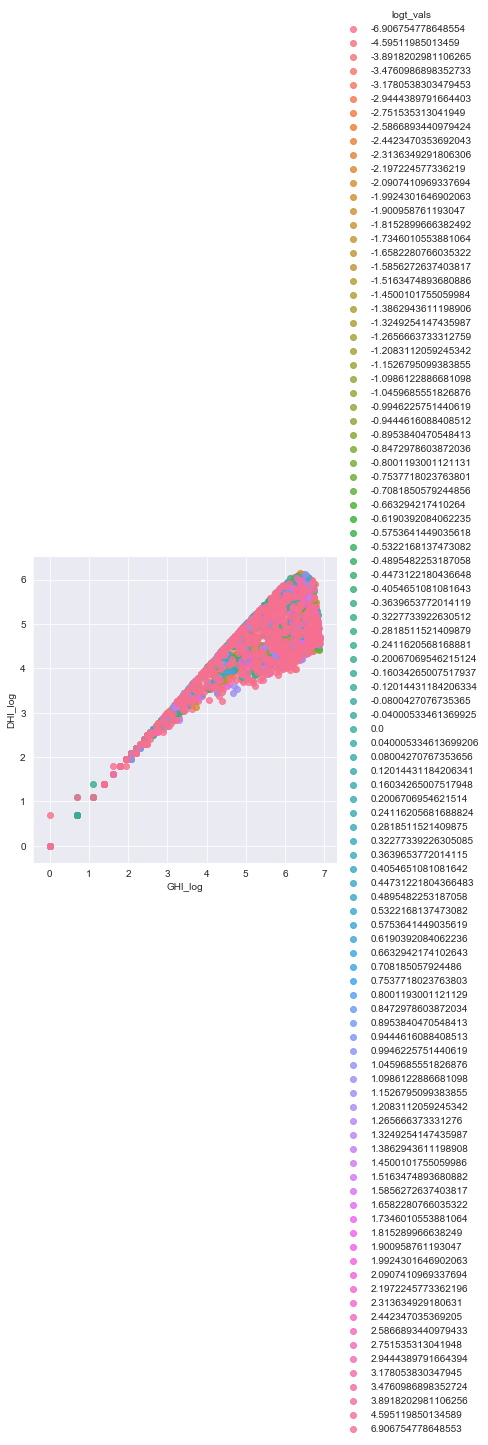

In [260]:
meta_visualization(df1_2018, x='GHI_log', y='DHI_log', z='logt_vals')

In [262]:
df2018_logit_regression = make_OLS(_X_logit, log_actuals)[0]

r2 is  0.7423416730220415


In [263]:
#Not bad, lets make some predictions
preds_logit_log = show_model_metrics(_X_logit, log_actuals, df2018_logit_regression)[0]

rmse is  0.5138504212530477
r2 is  0.7423416730220415
mean absolute error is  0.4333386346193195
mean squared log error is  0.012946941106587666
median absolute error is  0.41296677408060134
MAPE is  inf


In [264]:
preds_logit_log_backtrans = np.exp(preds_logit_log)
rmse = np.sqrt(mean_squared_error(actuals,preds_logit_log_backtrans))
r2 = r2_score(actuals,preds_logit_log_backtrans)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(actuals,preds_logit_log_backtrans))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_logit_log_backtrans))
print("median absolute error is ", median_absolute_error(actuals, preds_logit_log_backtrans))
print("MAPE is ", np.mean(np.abs((actuals - preds_logit_log_backtrans) / actuals)) * 100)

rmse is  71.42926359947775
r2 is  0.2741436234990742
mean absolute error is  49.7702454324471
mean squared log error is  0.2506578050311006
median absolute error is  35.117818711040776
MAPE is  45.945027741233076


In [183]:
#Similair to log log transformation

In [267]:
#Lets try with box cox with logit
_X_logit_2 = np.array(list(zip(box_cox_X, logit_vals)))
df2018_logit_regression2 = LinearRegression().fit(_X_logit_2, box_cox_Y)
df2018_logit_regression2.score(_X_logit_2, box_cox_Y)

0.5150425478934472

In [268]:
#no good. 

In [186]:
"""SUMMARY SO FAR
1.Best Models
    1. Polynomial fit on log transformed response 
        r2 is  0.7568685086844883
        mean absolute error is  0.39916258513543906
    2. OLS on log log transformed
        r2 is  0.744334589378747
        mean absolute error is  0.4313808973773106
    3. OLS on logit transformed cloud cover with log transformed feature and response
        r2 is 0.7423416730220415
        mean absolute error is  0.4333386346193195
    4. OLS power transformed for all variables
        r2 is 0.5152314620121814
    5. OLS on power transformation features and response with logit transformed cloud cover
        r2 is 0.5150425478934472
        
"""

'SUMMARY SO FAR\n1.Best Models\n    1. Polynomial fit on log transformed response \n        r2 is  0.7568685086844883\n        mean absolute error is  0.39916258513543906\n    2. OLS on log log transformed\n        r2 is  0.744334589378747\n        mean absolute error is  0.4313808973773106\n    3. OLS on logit transformed cloud cover with log transformed feature and response\n        r2 is 0.7423416730220415\n        mean absolute error is  0.4333386346193195\n    4. OLS power transformed for all variables\n        r2 is 0.5152314620121814\n    5. OLS on power transformation features and response with logit transformed cloud cover\n        r2 is 0.5150425478934472\n        \n'

In [187]:
#Let's go a complete new direction. Let's try generalized least squares
#since variance in Y for each X is different linear estimaters like OLS wont work
#The big issue is the distribution of residuals

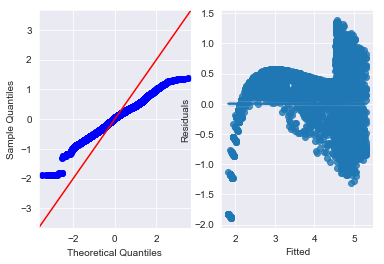

In [188]:
#Poly regression residuals
resids_viz(log_actuals, predictions_poly)

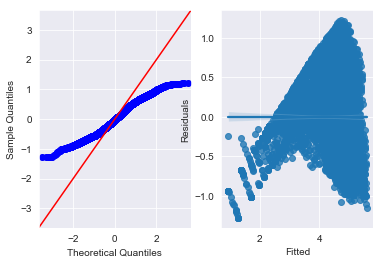

In [189]:
#Log-log regression resids
resids_viz(log_actuals, predictions_log)

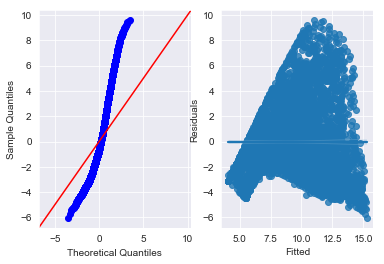

In [269]:
#sqrt regression resids
resids_viz(dhi_sqrt, dhi_sqrt_preds)

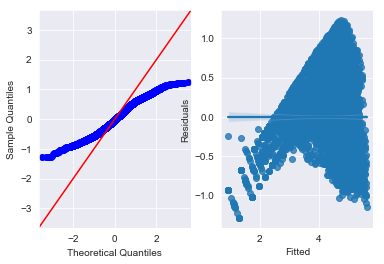

In [270]:
#Logit resids
resids_viz(log_actuals, preds_logit_log)

In [271]:
#GLS and WLS minimizes distance to residuals relative to covariance of those residuals

## Generalized Least Squares Regression

In [272]:
#Next approaches will use stats models instead of sklearn

In [273]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI_log'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params
print(rho)

[0.77665302]


In [274]:
"""rho is a consistent estimator of the correlation of the
residuals from an OLS fit of the data. 
It is assumed that this is the true rho of the AR process data.
"""

'rho is a consistent estimator of the correlation of the\nresiduals from an OLS fit of the data. \nIt is assumed that this is the true rho of the AR process data.\n'

In [275]:
from scipy.linalg import toeplitz
order = toeplitz(np.arange(len(df1_2018)))
sigma = rho**order

In [276]:
#sigma is an n x n matrix of the autocorrelation structure of the data.

In [277]:
gls_model = sm.GLS(endog, exog, sigma=sigma)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.925
Model:                            GLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                          2.762e+04
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:50:00   Log-Likelihood:                         -1513.4
No. Observations:                4494   AIC:                                      3031.
Df Residuals:                    4492   BIC:                                      3044.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [278]:
preds_gls = gls_results.predict()

In [279]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  0.531869820178268
mean squared log error is  0.01373431123017486
median absolute error is  0.5290450164986669


In [280]:
#Backtransformed
preds_gls_backtrans = np.exp(preds_gls)
print("mean absolute error is ",mean_absolute_error(actuals,preds_gls_backtrans))
print("mean squared log error is ", mean_squared_log_error(actuals, preds_gls_backtrans))
print("median absolute error is ", median_absolute_error(actuals, preds_gls_backtrans))
print("MAPE is ", np.mean(np.abs((actuals - preds_gls_backtrans) / actuals)) * 100)


mean absolute error is  54.75904407891222
mean squared log error is  0.35590061131376954
median absolute error is  40.25866543756527
MAPE is  48.172488269777595


## GLS in Log-Log Model

In [281]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI_log'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [282]:
gls_model = sm.GLS(endog, exog)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            GLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.391e+05
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:50:17   Log-Likelihood:                         -3770.3
No. Observations:                4494   AIC:                                      7545.
Df Residuals:                    4492   BIC:                                      7557.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [283]:
preds_gls = gls_results.predict()
residuals_gls = endog - preds_gls

In [284]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  0.47652160632172497
mean squared log error is  0.011371151925362992
median absolute error is  0.4512538875240555


In [285]:
#Predictions are off
#The line needs to fit! The data needs to be narrow

# Weighted Least Squares

In [286]:
#Step 1: Calculate Absolute Residuals from OLS model
#We are going to do this in the log log model

In [287]:
exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
ols_log_log_model = make_OLS(exog, df1_2018['DHI_log'])[0]
show_model_metrics(exog, df1_2018['DHI_log'], ols_log_log_model)
preds_ols_log_log = ols_log_log_model.predict(exog)
resids_ols_log_log = df1_2018['DHI_log'] - preds_ols_log_log
print(ols_log_log_model.intercept_, ols_log_log_model.coef_)

r2 is  0.7443373468957029
rmse is  0.511856557341785
r2 is  0.7443373468957029
mean absolute error is  0.43137791500130035
mean squared log error is  0.012859460767530978
median absolute error is  0.4127321641319177
MAPE is  inf
0.9348412285757397 [0.62767392 0.34339129]


In [289]:
residuals_wls_abs = abs(resids_ols_log_log)

In [290]:
#Step 2. Get weights for WLS. 
#Step 2a. Fit OLS regression of absolute residuals vs. predictor (GHI_log)

In [291]:
ols_weight_maker = make_OLS(exog, residuals_wls_abs)[0]
print(ols_weight_maker)

r2 is  0.03934174449591887
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)


In [292]:
#Step 2b. Use the predicted values of this model to calculate weights
weight_maker_fitted = ols_weight_maker.predict(exog)
print(weight_maker_fitted)
weights = 1/(weight_maker_fitted*weight_maker_fitted)
print(weights)

[0.33405958 0.4346227  0.4618814  ... 0.46908971 0.44915901 0.40502863]
[8.96091045 5.29389325 4.68747593 ... 4.54452168 4.95678132 6.09576971]


In [293]:
# Step 3 fit WLS using the sample weights
WLS_log_log = LinearRegression()
WLS_log_log.fit(exog, df1_2018['DHI_log'], sample_weight=weights)
show_model_metrics(exog, df1_2018['DHI_log'], WLS_log_log)
print(WLS_log_log.intercept_, WLS_log_log.coef_)

rmse is  0.5200281888598424
r2 is  0.7361090355538787
mean absolute error is  0.4404009838480973
mean squared log error is  0.010977072888332688
median absolute error is  0.4283322300679555
MAPE is  inf
0.6135397183055993 [0.69191054 0.32990634]


In [294]:
#Lets transform these to normal to see the real effects not deviations from geometric mean

In [295]:
WLS_preds_log = WLS_log_log.predict(exog)
WLS_preds = np.exp(WLS_preds_log)
actuals = df1_2018['DHI']
print("mean absolute error is ",mean_absolute_error(actuals,WLS_preds))
print("mean squared log error is ", mean_squared_log_error(actuals, WLS_preds))
print("median absolute error is ", median_absolute_error(actuals, WLS_preds))
print("MAPE is ", np.mean(np.abs((actuals - WLS_preds) / actuals)) * 100)

mean absolute error is  52.62384379323525
mean squared log error is  0.2611654811732442
median absolute error is  38.66210510957472
MAPE is  47.80563545205258


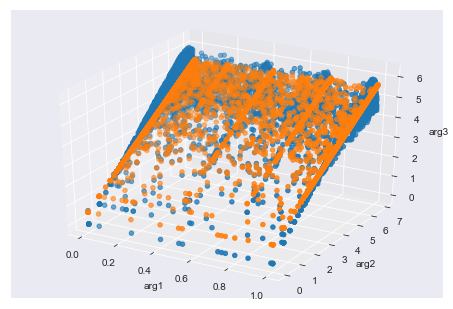

In [296]:
#3D visualization
three_dee_viz(df1_2018['Cloud Cover'],df1_2018['GHI_log'], df1_2018['DHI_log'], WLS_preds_log)

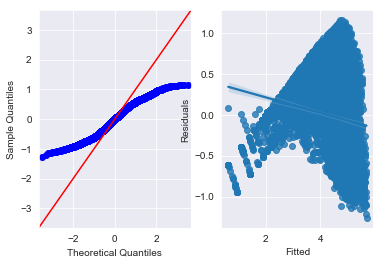

In [297]:
resids_viz(df1_2018['DHI_log'], WLS_preds_log)

In [298]:
#Sigh, this did not work

## Does adding seasons, air pressure, and other variables change explanatory power?

In [299]:
#Lets try with seasons

df1_2018 = seasonize(df1_2018)
print(df1_2018['Season'])

14      Winter
15      Winter
16      Winter
17      Winter
18      Winter
         ...  
8754       NaN
8755       NaN
8756       NaN
8757       NaN
8758       NaN
Name: Season, Length: 4494, dtype: object


<class 'numpy.int64'>
<class 'str'>


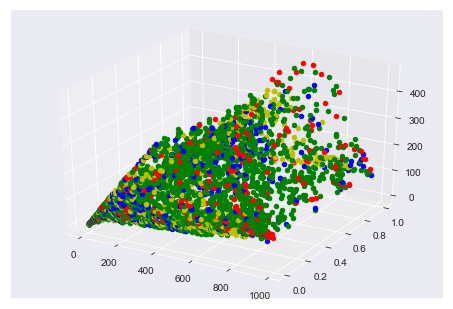

In [300]:
#See the data
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi = df1_2018['GHI'].values
dhi = df1_2018['DHI'].values
cloud_cover = df1_2018['Cloud Cover'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(ghi[i], cloud_cover[i], dhi[i], c=colors[i])
plt.show()
    



In [301]:
#Honestly, even with seasons, high variation across the board

In [302]:
#turn into dummy variables
dummies = pd.get_dummies(df1_2018['Season'], drop_first=True)
df1_2018 = df1_2018.join(dummies)
print(df1_2018.head())

    Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14  2018      1    1    14      30        -24.4            17           323   
15  2018      1    1    15      30        -22.4            37           762   
16  2018      1    1    16      30        -20.3            48           896   
17  2018      1    1    17      30        -18.5            54           955   
18  2018      1    1    18      30        -17.0            56           976   

    Clearsky GHI  Cloud Type  ...  box_cox_X2  box_cox_Y   ghi_sqrt  \
14            29           8  ...   -1.035325   0.655390  13.304135   
15           171           8  ...   -1.035325   0.307221  13.341664   
16           306           0  ...   -1.035325  -0.084083  11.704700   
17           400           0  ...   -1.035325  -1.207801   5.385165   
18           440           0  ...    1.314466  -1.828880   3.162278   

     dhi_sqrt  cc_sqrt  logt_vals  Season  Spring  Summer  Winter  
14  12.124356      0.0  -6.906

In [303]:
#Get values and perform linear regression

# fall = (df1_2018['Fall'].values)
winter = (df1_2018['Winter'].values)
spring = (df1_2018['Spring'].values)
summer = (df1_2018['Summer'].values)
print(winter)
print(type(winter[0]))

[1 1 1 ... 0 0 0]
<class 'numpy.uint8'>


In [304]:
X_4dim = list(zip(ghi, cloud_cover, winter, spring, summer))
dim4_regression = LinearRegression().fit(X_4dim, dhi)

In [305]:
model_4dim  = make_OLS(X_4dim, dhi)[0]

r2 is  0.2536739894472665


In [306]:
show_model_metrics(X_4dim, dhi, model_4dim)

rmse is  72.4294376728498
r2 is  0.2536739894472665
mean absolute error is  54.472081441406786
mean squared log error is  0.6686964685061408
median absolute error is  42.974827203516746
MAPE is  158.07203552981036


(array([ 60.49382132,  89.67121363, 108.19100342, ..., 110.01169802,
         94.47817194,  78.54745731]),
 array([-48.49382132, -36.67121363, -48.19100342, ..., -21.01169802,
        -25.47817194, -45.54745731]))

In [307]:
#Bad. Lets see some p tests to see if weather changes things

In [308]:
#Screw this using statsmodels so muhc easier than sklearn
_X = sm.add_constant(X_4dim)
est = sm.OLS(dhi, _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     305.1
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          7.28e-282
Time:                        10:52:04   Log-Likelihood:                -25623.
No. Observations:                4494   AIC:                         5.126e+04
Df Residuals:                    4488   BIC:                         5.130e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.9054      2.312     18.987      0.0

In [309]:
#Weather doesnt seem to have explanatory power and has collinearity problems

In [310]:
X_3dim = list(zip(ghi, cloud_cover, dhi))

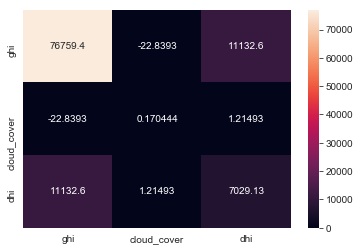

In [311]:
#Speaking of which, lets take a look at the covariance matrix
covMatrix = np.cov(X_3dim, rowvar=False, bias=True)
sns.heatmap(covMatrix, annot=True, fmt='g', xticklabels = ['ghi','cloud_cover','dhi'], yticklabels = ['ghi','cloud_cover','dhi'] )
plt.show()

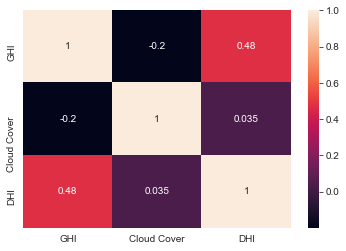

In [312]:
correlMatrix = df1_2018[['GHI', 'Cloud Cover', 'DHI', 'Season']].corr()
sns.heatmap(correlMatrix, annot=True)
plt.show()

In [313]:
#lets see if air pressure changes anything
#GHI and DHI are correlated/


In [314]:
pressure = df1_2018['Pressure'].values
X_5dim = list(zip(ghi, cloud_cover, winter, spring, summer, pressure))


In [315]:
model_5dim  = make_OLS(X_5dim, dhi)[0]

r2 is  0.26243009868497613


In [316]:
#5 dim model with seasons and pressure added
show_model_metrics(X_5dim, dhi, model_5dim)

rmse is  72.00330270914755
r2 is  0.26243009868497613
mean absolute error is  53.87420310812145
mean squared log error is  0.6635571403493165
median absolute error is  42.381497175764025
MAPE is  157.90337666595252


(array([ 35.17496564,  65.29974346,  83.3683321 , ..., 101.0706329 ,
         84.39606389,  67.30898603]),
 array([-23.17496564, -12.29974346, -23.3683321 , ..., -12.0706329 ,
        -15.39606389, -34.30898603]))

In [317]:
#Screw this using statsmodels so much easier than sklearn
_X = sm.add_constant(X_5dim)
est = sm.OLS(dhi, _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 03 Apr 2020   Prob (F-statistic):          4.54e-292
Time:                        10:52:16   Log-Likelihood:                -25596.
No. Observations:                4494   AIC:                         5.121e+04
Df Residuals:                    4487   BIC:                         5.125e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1144.8121    150.858      7.589      0.0

In [318]:
#That was not good
#Strong multicollinearity with season

In [319]:
#Lets do an OLS on log transformed values with possibly useful other valiues

In [320]:
#Model with log transformation, seasons, pressure
x_3dim2 = list(zip(df1_2018['GHI_log'].values, cloud_cover, winter, spring, summer, pressure))


In [321]:
model_3dim2  = make_OLS(x_3dim2, df1_2018['DHI_log'].values)[0]

r2 is  0.7510824418668567


In [322]:
show_model_metrics(x_3dim2,df1_2018['DHI_log'].values, model_3dim2 )

rmse is  0.5050593222457903
r2 is  0.7510824418668567
mean absolute error is  0.42415578582574
mean squared log error is  0.012740533859289081
median absolute error is  0.40355710437699654
MAPE is  inf


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


(array([2.49416243, 3.96540266, 4.47126005, ..., 4.65260791, 4.32013745,
        3.60007329]),
 array([-0.00925578,  0.00488925, -0.37691549, ..., -0.16397154,
        -0.08603095, -0.10356573]))

In [323]:
_X = sm.add_constant(x_3dim2)
est = sm.OLS(df1_2018['DHI_log'], _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                DHI_log   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     2257.
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:52:19   Log-Likelihood:                -3307.0
No. Observations:                4494   AIC:                             6628.
Df Residuals:                    4487   BIC:                             6673.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.6533      1.058     11.013      0.0

In [324]:
#Evidence for multicollinearity amongst seasons, air pressure seems to help a bit

In [325]:
#Lets see if removing seasons helps

In [326]:
X_4dim = list(zip(df1_2018['GHI_log'], cloud_cover, pressure))
_X = sm.add_constant(X_4dim)
est = sm.OLS(df1_2018['DHI_log'], _X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                DHI_log   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     4489.
Date:                Fri, 03 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:52:20   Log-Likelihood:                -3317.0
No. Observations:                4494   AIC:                             6642.
Df Residuals:                    4490   BIC:                             6668.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4965      1.051     10.935      0.0

In [327]:
model_4dim = make_OLS(X_4dim, df1_2018['DHI_log'])[0]

r2 is  0.7499617490148884


In [328]:
show_model_metrics(X_4dim, df1_2018['DHI_log'], model_4dim)

rmse is  0.5061950008971886
r2 is  0.7499617490148884
mean absolute error is  0.42486755616567545
mean squared log error is  0.012739260631985777
median absolute error is  0.4010005131858039
MAPE is  inf


(array([2.47427053, 3.94841812, 4.45492168, ..., 4.68214602, 4.34932478,
        3.62825468]),
 14      0.010636
 15      0.021874
 16     -0.360577
 17     -0.393724
 18     -0.546596
           ...   
 8754   -0.794430
 8755   -0.207945
 8756   -0.193510
 8757   -0.115218
 8758   -0.131747
 Name: DHI_log, Length: 4494, dtype: float64)

In [329]:
#To be honest, it doesn't seem like air pressure helps a whole lot

In [330]:
#Lets see what the data looks like

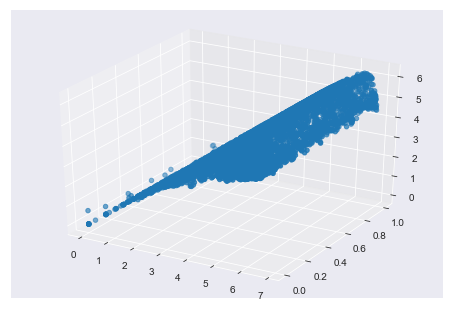

In [331]:

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df1_2018['GHI_log'], df1_2018['Cloud Cover'], df1_2018['DHI_log'])
plt.show()
    


<class 'numpy.int64'>
<class 'str'>


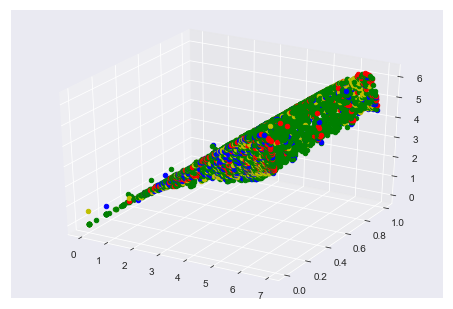

In [332]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(ghi_log[i], cloud_cover[i], dhi_log[i], c=colors[i])
plt.show()
    


<class 'numpy.int64'>
<class 'str'>


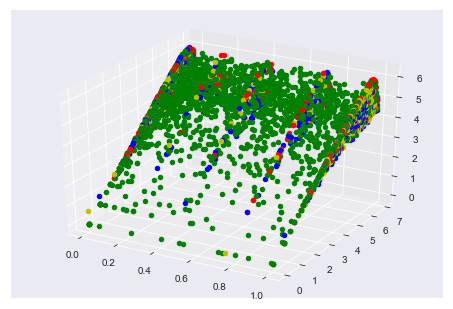

In [333]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    


In [334]:
#Probably too much variation again. Model still has alot of variation
#But now with the colors you can see the depth of the model
#One reason why the seasons are so screwed up is because  the summer months
#Have such sspread, there are no readings in between 0.2,0.44,.74 that arent summer

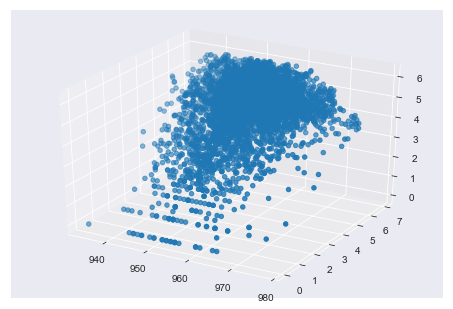

In [335]:
#Lets see with pressure
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df1_2018['Pressure'],df1_2018['GHI_log'],  df1_2018['DHI_log'])
plt.show()
    


In [336]:
#Lots of variation

In [337]:
print(df1_2018.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'timestamps', 'Cloud Cover', 'DHI_log', 'GHI_log',
       'cloud_cover_log', 'box_cox_X', 'box_cox_X2', 'box_cox_Y', 'ghi_sqrt',
       'dhi_sqrt', 'cc_sqrt', 'logt_vals', 'Season', 'Spring', 'Summer',
       'Winter'],
      dtype='object')


<class 'numpy.int64'>
<class 'str'>


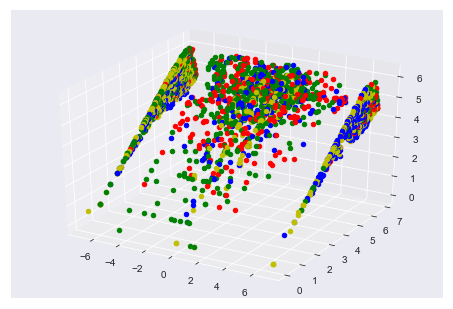

In [338]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
cloud_cover_logt = df1_2018['logt_vals'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover_logt[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    

In [339]:
#This helps with middle values. Honestly, I may have to just bucket the cloud cover values

In [340]:
#Fit without intercept, lets see what happens
X_2dim = list(zip(df1_2018['GHI_log'], cloud_cover))
second_order_model_nointercept = LinearRegression(fit_intercept=False)
second_order_model_nointercept.fit(X_2dim, df1_2018['DHI_log'])
second_order_model_nointercept.score(X_2dim, df1_2018['DHI_log'])

0.6940792541195075

In [341]:
#Fit without interceopt and with pressure
X_2dim = list(zip(df1_2018['GHI_log'], cloud_cover, pressure))
second_order_model_nointercept = LinearRegression(fit_intercept=False)
second_order_model_nointercept.fit(X_2dim, df1_2018['DHI_log'])
second_order_model_nointercept.score(X_2dim, df1_2018['DHI_log'])

0.7433034575256099

In [342]:
show_model_metrics(X_2dim, df1_2018['DHI_log'], second_order_model_nointercept)

rmse is  0.5128904766635823
r2 is  0.7433034575256099
mean absolute error is  0.4323042265919951
mean squared log error is  0.012827194956932879
median absolute error is  0.4133224574707085
MAPE is  inf


(array([2.76117371, 4.22738921, 4.73934545, ..., 4.76917541, 4.44787698,
        3.73785587]),
 14     -0.276267
 15     -0.257097
 16     -0.645001
 17     -0.671985
 18     -0.817452
           ...   
 8754   -0.857763
 8755   -0.283135
 8756   -0.280539
 8757   -0.213770
 8758   -0.241348
 Name: DHI_log, Length: 4494, dtype: float64)

In [343]:
#Fit with interceopt and with pressure
X_2dim = list(zip(df1_2018['GHI_log'], cloud_cover, pressure))
second_order_model_nointercept = LinearRegression(fit_intercept=True)
second_order_model_nointercept.fit(X_2dim, df1_2018['DHI_log'])
second_order_model_nointercept.score(X_2dim, df1_2018['DHI_log'])

0.7499617490148884

In [344]:
# _X = sm.add_constant(X_2dim)
est = sm.OLS(df1_2018['DHI_log'], X_2dim)
est2 = est.fit()
print(est2.summary())

                                 OLS Regression Results                                
Dep. Variable:                DHI_log   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.108e+05
Date:                Fri, 03 Apr 2020   Prob (F-statistic):                        0.00
Time:                        10:53:45   Log-Likelihood:                         -3376.1
No. Observations:                4494   AIC:                                      6758.
Df Residuals:                    4491   BIC:                                      6777.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [345]:
def model_2dim_manual(ghi, cloudCover, pressure):
    ans = 0.6293*(ghi) + 0.019*(cloudCover) + pressure*(3.31e-05)
    ans = np.exp(ans)
    return ans


In [346]:
preds = []
ghi = df1_2018['GHI_log'].values
pressure = df1_2018['Pressure'].values
for i in range(len(ghi)):
    p = model_2dim_manual(ghi[i], cloud_cover[i], pressure[i])
    preds.append(p)

actuals = df1_2018['DHI'].values

print("mean absolute error is ",mean_absolute_error(actuals,preds))
print("mean squared log error is ", mean_squared_log_error(actuals, preds))
print("median absolute error is ", median_absolute_error(actuals, preds))
print("MAPE is ", np.mean(np.abs((actuals - preds) / preds)) * 100)

mean absolute error is  72.64794223427
mean squared log error is  1.2608709135869334
median absolute error is  45.02997307591575
MAPE is  219.47960021449816


In [347]:
#Looks like this is a fools errand

In [348]:
#Bucketing probably wont work

In [349]:
#We need to squeeze these points together

In [350]:
print(df1_2018.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'timestamps', 'Cloud Cover', 'DHI_log', 'GHI_log',
       'cloud_cover_log', 'box_cox_X', 'box_cox_X2', 'box_cox_Y', 'ghi_sqrt',
       'dhi_sqrt', 'cc_sqrt', 'logt_vals', 'Season', 'Spring', 'Summer',
       'Winter'],
      dtype='object')


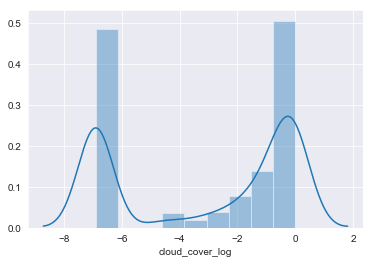

In [351]:
cloud_cover_log = np.log(df1_2018['Cloud Cover'].values)
df1_2018['cloud_cover_log'] = cloud_cover_log
sns.distplot(df1_2018['cloud_cover_log'])


In [352]:
#Data still two tailed

<class 'numpy.float64'>
<class 'str'>


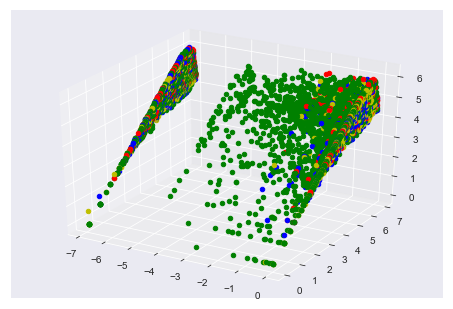

In [353]:
#Visualize with seasons
colors = []
for i in df1_2018['Season']:
    if i == 'Fall':
        colors.append('r')
    elif i == 'Winter':
        colors.append('b')
    elif i == 'Spring':
        colors.append('y')
    else:
        colors.append('g')
ghi_log = df1_2018['GHI_log'].values
dhi_log = df1_2018['DHI_log'].values
cloud_cover = df1_2018['Cloud Cover'].values
cloud_cover_log = df1_2018['cloud_cover_log'].values
s = df1_2018['Season'].values
print(type(ghi[9]))
print(type(s[9]))

fig = pyplot.figure()
ax = Axes3D(fig)

for i in range(len(ghi)):
    ax.scatter(cloud_cover_log[i], ghi_log[i],  dhi_log[i], c=colors[i])
plt.show()
    

In [354]:
x_log = list(zip(df1_2018['GHI_log'], df1_2018['cloud_cover_log']))
make_OLS(x_log, df1_2018['DHI_log'])

r2 is  0.7373909827125325


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
          normalize=False),
 0.7373909827125325)

In [355]:
print(df1_2018.columns)

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Clearsky DHI',
       'Clearsky DNI', 'Clearsky GHI', 'Cloud Type', 'Dew Point', 'DHI', 'DNI',
       'Fill Flag', 'GHI', 'Relative Humidity', 'Solar Zenith Angle',
       'Surface Albedo', 'Pressure', 'Precipitable Water', 'Wind Direction',
       'Wind Speed', 'timestamps', 'Cloud Cover', 'DHI_log', 'GHI_log',
       'cloud_cover_log', 'box_cox_X', 'box_cox_X2', 'box_cox_Y', 'ghi_sqrt',
       'dhi_sqrt', 'cc_sqrt', 'logt_vals', 'Season', 'Spring', 'Summer',
       'Winter'],
      dtype='object')
